# 2018-12-07 - Scanning STDP params

# TODO :
trouver un moyen de faire la densité du rasterplot
# TODO : 
Optimal scanning adapted from prior scans

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def VanillaRasterPlot(SpikesP, SpikesE, SpikesI, title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
            
        fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = figsize)
        plot_spiketrains(axs[0][0], SpikesP, color = 'k', ylabel = 'Neuron Index', do_ticks = False)
        axs[0][0].set_title('Poisson input')
        plot_spiketrains(axs[1][0], SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs[1][0].set_title('Inhibitory population')
        plot_spiketrains(axs[2][0], SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs[2][0].set_title('Excitatory population')
        plt.xlabel('Time(ms)')
        fig.suptitle(title, fontsize=12)
        return fig, axs

def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None):
    #extracts the spiketrains
    spiketrain_len = []
    for spiketrain in np.asarray(spike_array.spiketrains):
        spiketrain_len.append(len(np.array(spiketrain, dtype = float)))
    spikelen_array = np.asarray(spiketrain_len)
    
    #fit the gaussian
    x = np.linspace(0, popsize,popsize)
    y = np.asarray(spikelen_array)

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws)
    ax.set_title(r'$\sigma$ ' +out.fit_report(min_correl=.25).split('sigma')[1].split('+')[0])
    
    return ax

def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, 
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        axs4 = plt.subplot(gs[: , 4:])
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        fit_plot(popsize, SpikesE, axs4)
        fit_plot(popsize, SpikesP, axs4, datacol = '.g', fitcol = 'g', data_kws = {'alpha':0})
        axs4.set_xlabel('Neuron index')
        axs4.set_ylabel('Total spikes', rotation = 270)
        axs4.yaxis.tick_right()
        axs4.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig
    
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM
    

# Scanning STDP Tau constant

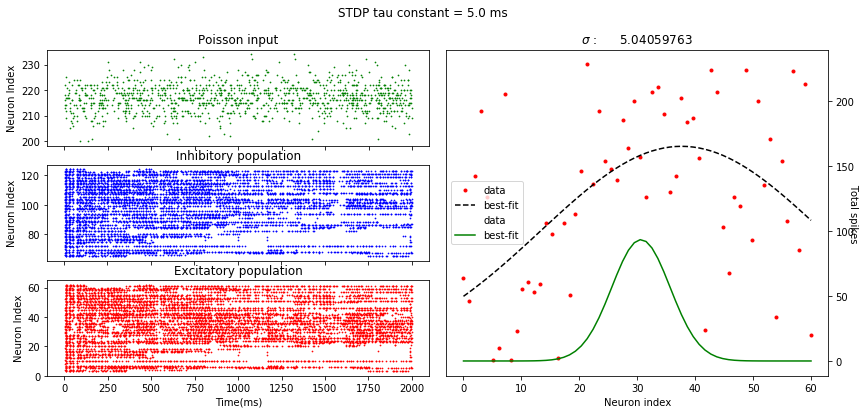

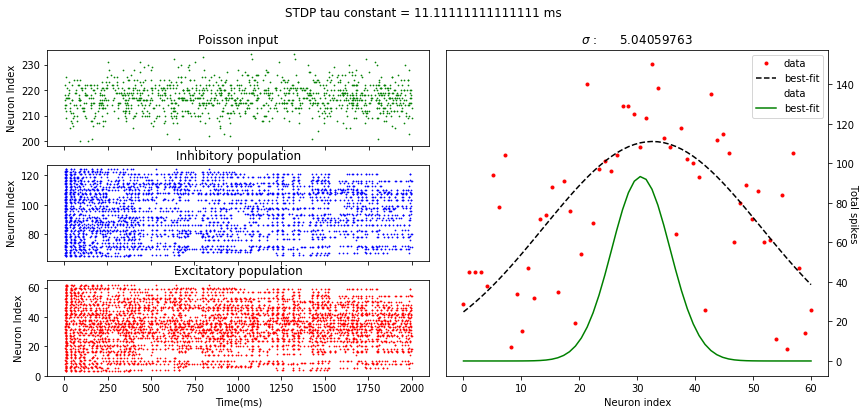

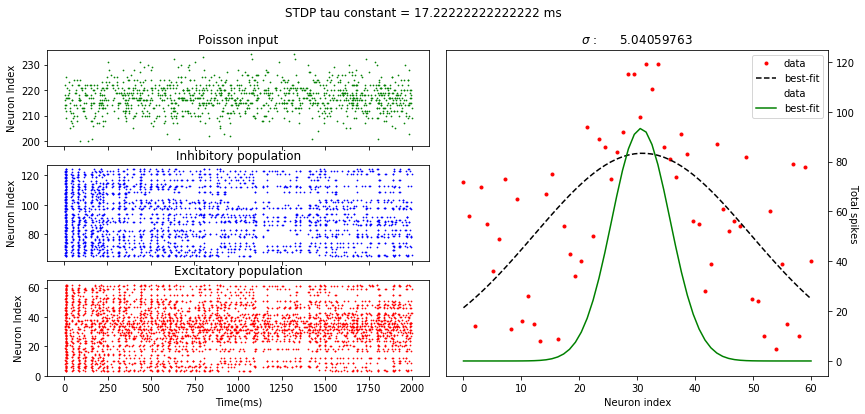

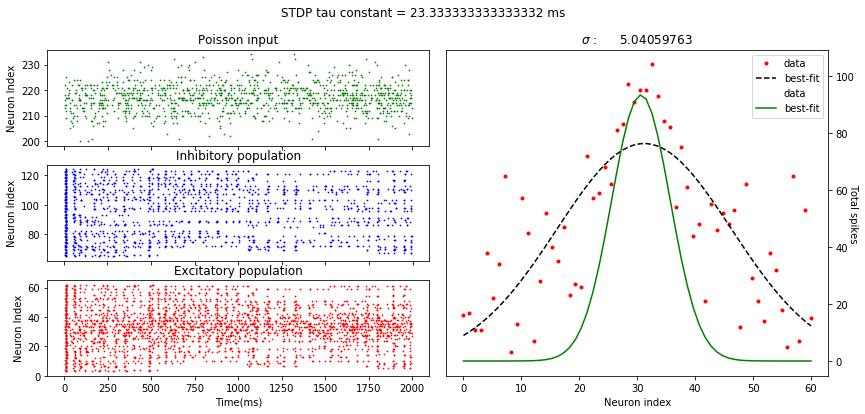

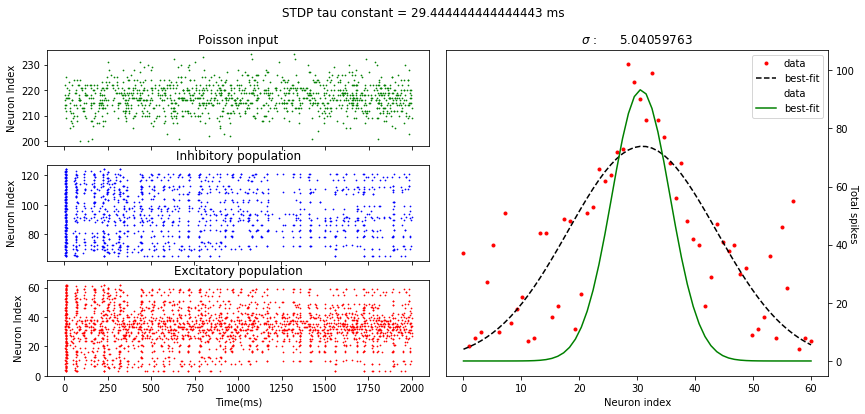

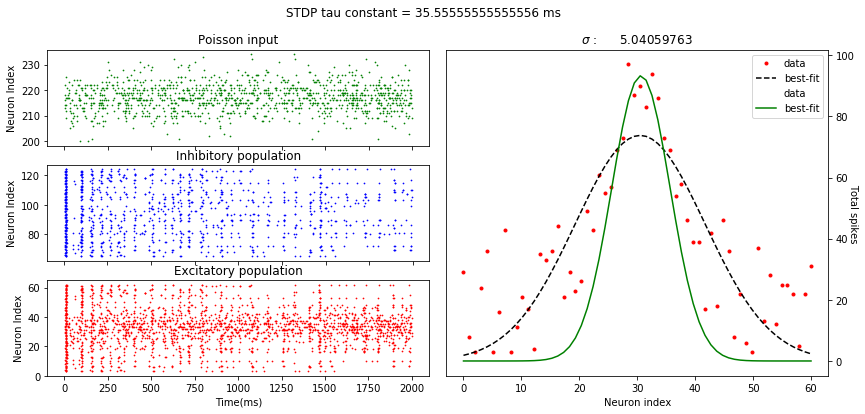

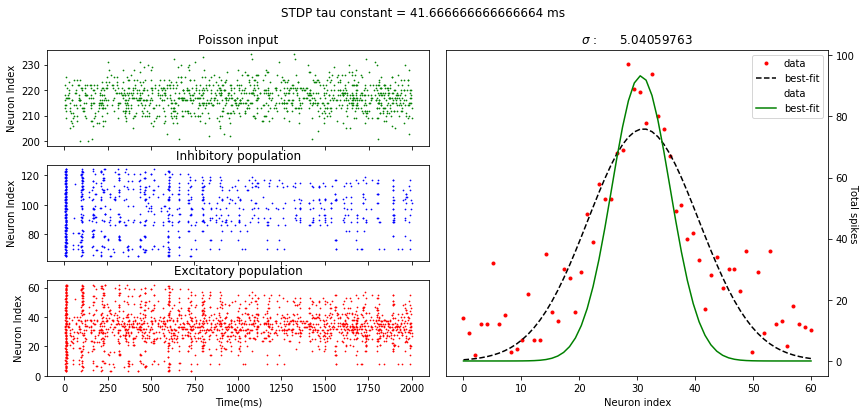

/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/recording/__init__.py:264: UserWarning: Recorded at least one spike after t_stop
  warn("Recorded at least one spike after t_stop")


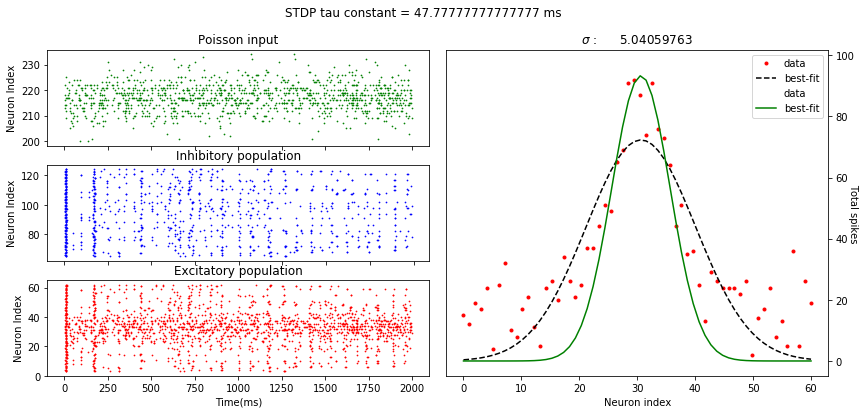

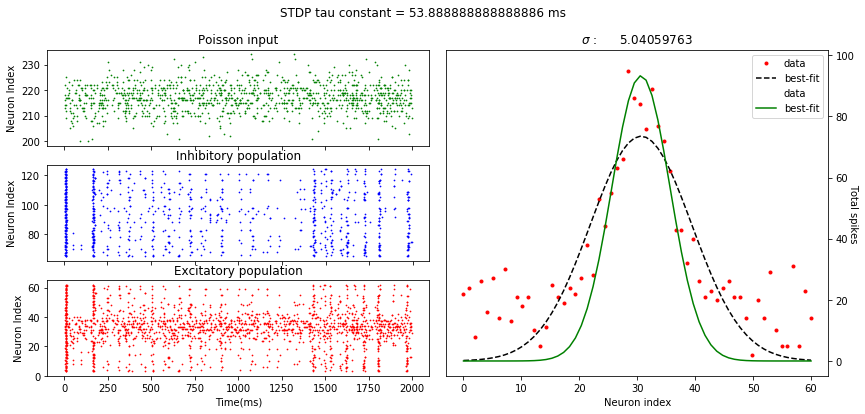

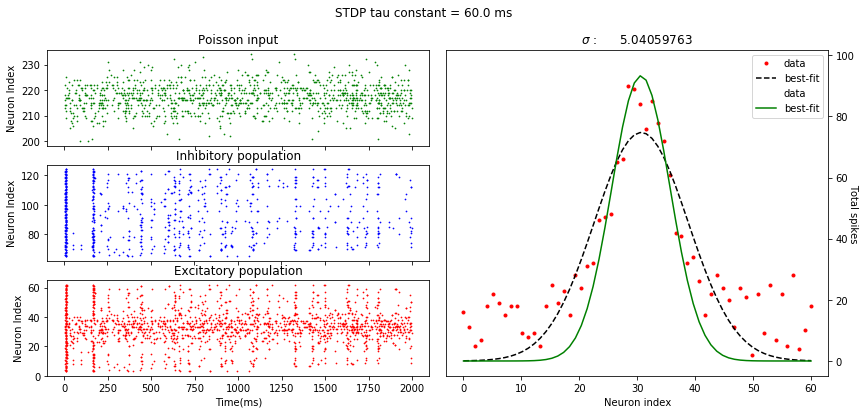

In [3]:
# Hyperparameters
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 90  # degrees
b_theta = 30  # degrees
sparseness = .1

taus = np.linspace(5, 60, 10)

for iterator, tau in enumerate(taus):
    normal_weights = rnd('normal_clipped', mu=.5, sigma=.2, low=0.1,
                         high=5,
                         rng=rng)
    delays = rnd('normal_clipped', mu=2, sigma=.5, low=0.1,
                 high=5,
                 rng=rng)
    sim.setup(timestep=.1, threads=4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=500, duration=simtime, start=0),
                               label="Entree Orientation")

    STDP_syn = sim.STDPMechanism(
        timing_dependence=sim.SpikePairRule(tau_plus=tau, tau_minus=tau,
                                            A_plus=0.9, A_minus=0.9),
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=1),
        weight=1,
        delay=delays,
        dendritic_delay_fraction=1.)

    # Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=.6, delay=1),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                    weight=.6, delay=1),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=sim.StaticSynapse(
                                     weight=.6, delay=1),
                                 receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime)
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    fig = SuperPlotter(inp_data, exc_data, inh_data,
                 60,
                 title='STDP tau constant = %s ms ' % tau,
                 figsize = (14,6)
                 )
    #fit_plot(n_pop, exc_data)
    
    plt.show()
    if iterator == 0 or iterator == 7 :
        fig.savefig('./figs/2018_12_10_RING_STDP_tau_iter%s.pdf'%iterator, format = 'pdf', dpi = 200)
    
    plt.pause(.1)

# Scanning STDP amplitude as a ratio of the input weight

/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/recording/__init__.py:264: UserWarning: Recorded at least one spike after t_stop
  warn("Recorded at least one spike after t_stop")


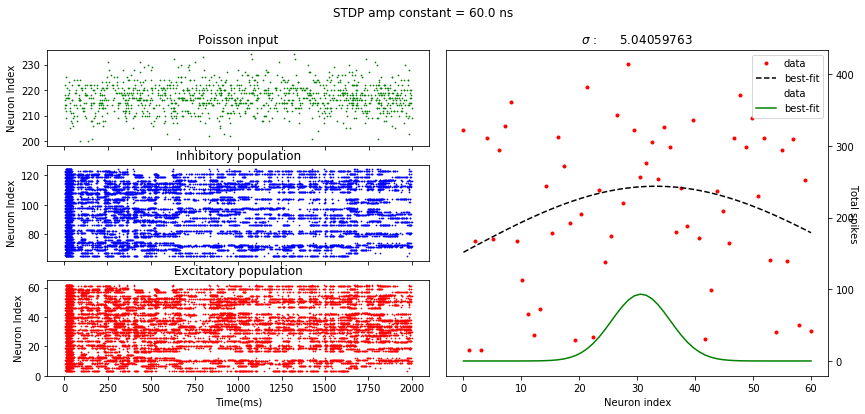

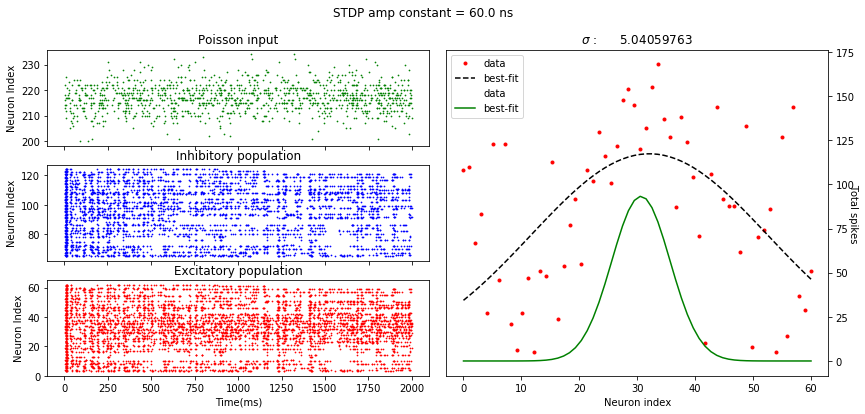

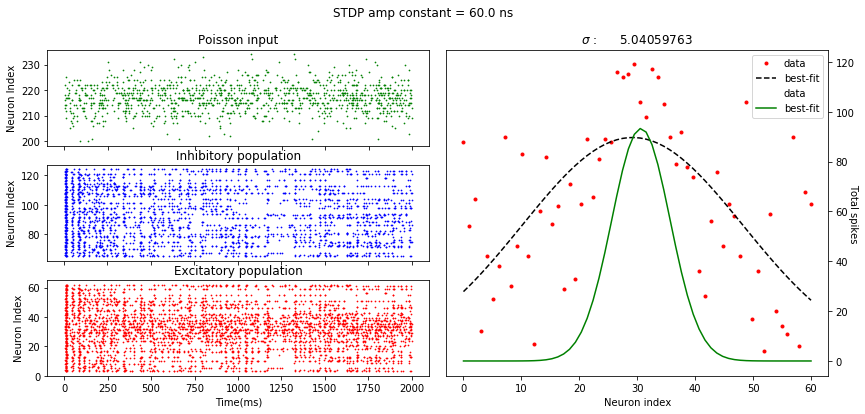

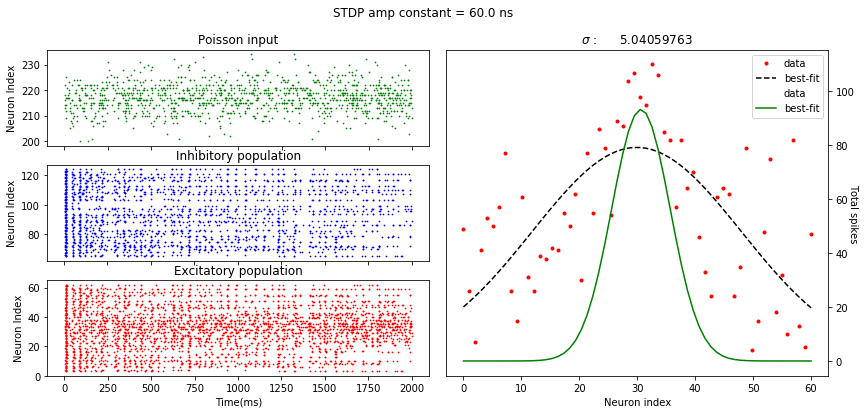

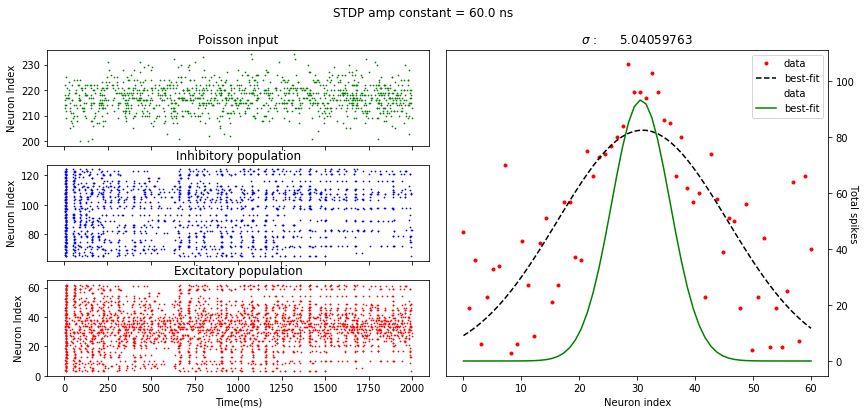

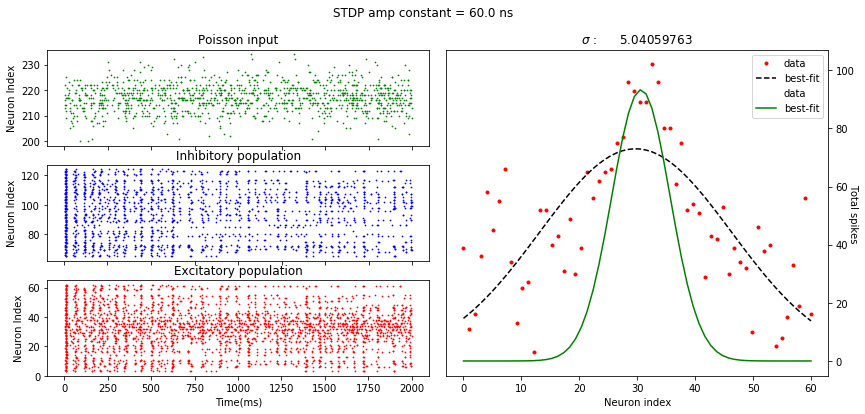

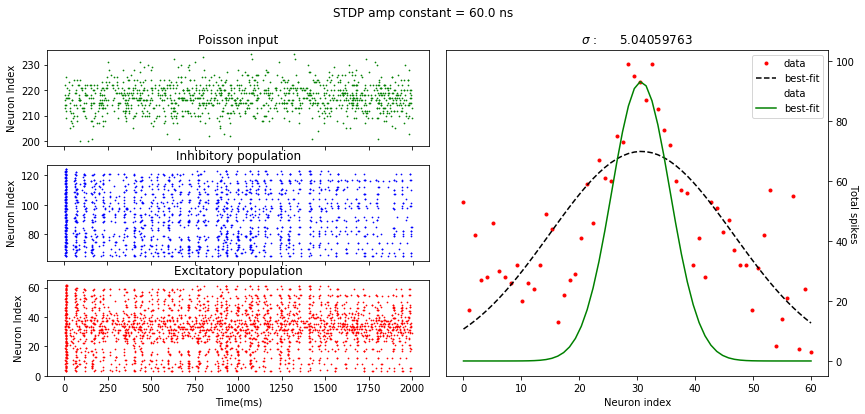

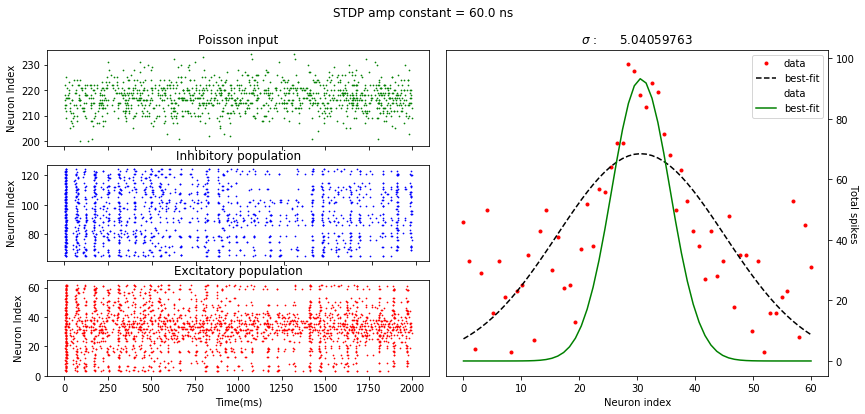

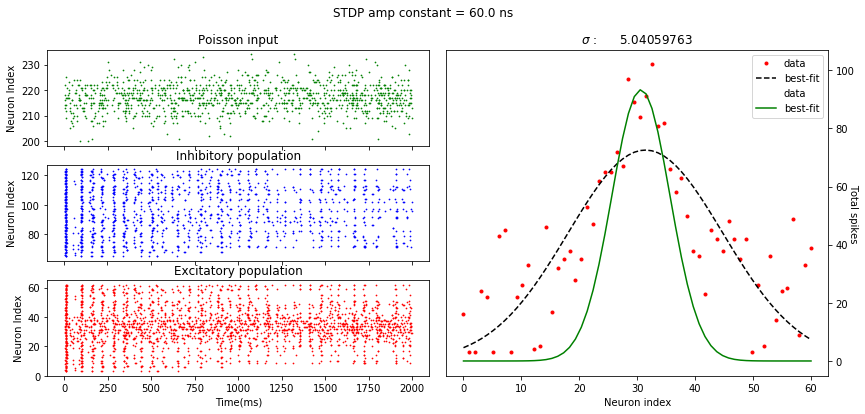

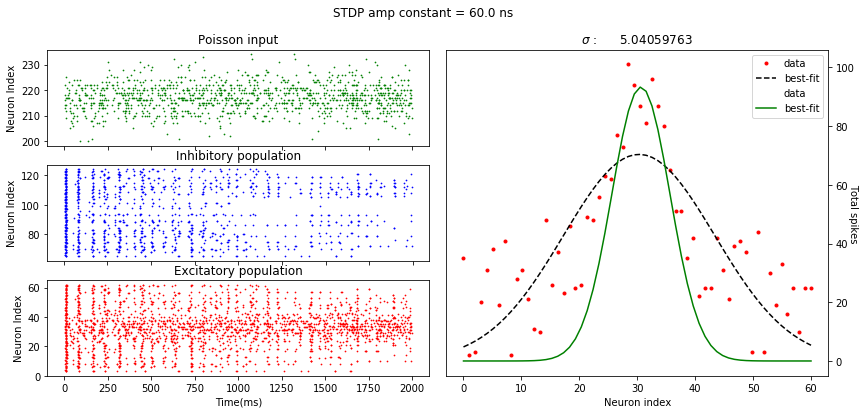

In [4]:
STDP_amps = np.linspace(.1, 5, 10)

for STDP_amp in STDP_amps :
    normal_weights = rnd('normal_clipped', mu=.5,sigma=.2, low = 0.1, 
                       high = 5,
                       rng = rng)
    delays = rnd('normal_clipped', mu=2,sigma=.5, low = 0.1, 
                       high = 5,
                       rng = rng)
    sim.setup(timestep = .1, threads = 4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                        initial_values={"v": neuron_parameters["v_reset"]},
                        label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                        initial_values={"v": neuron_parameters["v_reset"]},
                        label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop, 
                               sim.SpikeSourcePoisson(rate=500, duration=simtime, start = 0),
                        label="Entree Orientation")

    STDP_syn= sim.STDPMechanism(
                        timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                            A_plus=STDP_amp*.5, A_minus=STDP_amp*.5),
                        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=1),
                        weight=1,
                        delay=delays,
                        dendritic_delay_fraction=1.)

    #Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=STDP_syn,
                                receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(weight = .6, delay = 1),
                                receptor_type='inhibitory') #we can't have two types of synapses now can we ?

    #Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=STDP_syn,
                                receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(weight = .6, delay = 1),
                                receptor_type='inhibitory')

    #Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                connector=sim.OneToOneConnector(),
                                synapse_type=sim.StaticSynapse(weight = .6, delay = 1) ,
                                receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime)
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    SuperPlotter(inp_data, exc_data, inh_data,
                 60,
                 title='STDP amp constant = %s ns ' % tau,
                 figsize = (14,6)
                 )
    plt.show()
    plt.pause(.1)

# Scanning weight mu

In [5]:
weight_mus = np.linspace(.1, 5, 10)

for weight_mu in weight_mus :
    normal_weights = rnd('normal_clipped', mu=weight_mu,sigma=.2, low = 0.1, 
                       high = 5,
                       rng = rng)
    delays = rnd('normal_clipped', mu=2,sigma=.5, low = 0.1, 
                       high = 5,
                       rng = rng)
    sim.setup(timestep = .1, threads = 4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                        initial_values={"v": neuron_parameters["v_reset"]},
                        label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                        initial_values={"v": neuron_parameters["v_reset"]},
                        label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop, 
                               sim.SpikeSourcePoisson(rate=500, duration=simtime, start = 0),
                        label="Entree Orientation")

    STDP_syn= sim.STDPMechanism(
                        timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                            A_plus=.9, A_minus=.9),
                        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=1),
                        weight=1,
                        delay=delays,
                        dendritic_delay_fraction=1.)

    #Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=STDP_syn,
                                receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(weight = weight_mus, delay = 1),
                                receptor_type='inhibitory') #we can't have two types of synapses now can we ?

    #Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=STDP_syn,
                                receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(weight = weight_mus, delay = 1),
                                receptor_type='inhibitory')

    #Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                connector=sim.OneToOneConnector(),
                                synapse_type=sim.StaticSynapse(weight = weight_mus, delay = 1) ,
                                receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime)
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    SuperPlotter(inp_data, exc_data, inh_data,
                 60,
                 title='Weight mu = %s ns ' % tau,
                 figsize = (14,6)
                 )
    plt.show()
    plt.pause(.1)

ValueError: Lazy array has fixed shape (10,), cannot be changed to (60, 60)

In [ ]:
plt.plot(rates)
plt.xlabel('Neuron index')
plt.ylabel('Firing rate')
plt.title('Input curve')
plt.show()

In [ ]:
def update_rate():
    '''
    Updates the firing rate of the input population to make a dynamically rotating tuning curve
    TODO : It's for V2, right now just a static version will already be nice enough.
    '''